EDA guide: https://miykael.github.io/blog/2022/advanced_eda/

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from scipy import stats
import numpy as np
import seaborn as sns
import xgboost as xgb
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import RFE
# from tsfresh import extract_features

In [2]:
train_targets = pd.read_parquet('./data/A/train_targets.parquet')
X_test_estimated = pd.read_parquet('./data/A/X_test_estimated.parquet')
X_train_estimated = pd.read_parquet('./data/A/X_train_estimated.parquet')
X_train_observed = pd.read_parquet('./data/A/X_train_observed.parquet')

In [3]:
X_train_observed.describe()

,date_forecast,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,...,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms
count,118669,118669.000000,118669.000000,96422.000000,1.186690e+05,118669.000000,110603.000000,118669.000000,118669.000000,118669.000000,...,118669.000000,118669.000000,118669.000000,118669.000000,118669.000000,118669.000000,118669.000000,118669.000000,118669.000000,118669.000000
mean,2021-02-09 23:30:00.000000512,6.652576,1.249064,2907.949219,5.994018e+05,166.500381,1737.142212,0.022398,276.823395,44.918282,...,179.629486,1.529545,0.059087,280.708557,74.401077,32446.992188,3.043197,0.756781,0.517437,0.000019
min,2019-06-02 22:00:00,0.700000,1.145000,27.799999,0.000000e+00,0.000000,27.900000,-1.000000,250.899994,0.000000,...,0.002000,-50.004002,0.000000,258.899994,0.000000,154.300003,0.000000,-7.300000,-9.300000,-0.000000
25%,2020-04-06 22:45:00,4.400000,1.224000,1102.900024,0.000000e+00,0.000000,590.700012,0.000000,272.100006,0.000000,...,88.487999,-15.066000,0.000000,275.899994,54.799999,15592.400391,1.700000,-1.400000,-0.700000,0.000000
50%,2021-02-09 23:30:00,6.300000,1.247000,1882.400024,3.574770e+04,8.600000,1162.599976,0.000000,277.200012,4.100000,...,179.436996,1.202000,0.000000,280.700012,93.699997,36359.800781,2.700000,0.400000,0.500000,0.000000
75%,2021-12-16 00:15:00,8.600000,1.272000,3969.750000,1.037819e+06,288.799988,2079.600098,0.000000,282.000000,76.000000,...,270.640991,18.995001,0.100000,285.200012,99.900002,48084.500000,4.100000,2.700000,1.700000,0.000000
max,2022-10-21 01:00:00,17.500000,1.427000,12328.500000,3.005720e+06,836.400024,11688.700195,1.000000,293.799988,345.700012,...,359.997986,49.999001,1.400000,303.299988,100.000000,71349.898438,15.200000,12.300000,8.600000,0.100000
std,NaN,2.796409,0.036317,2570.401855,8.797980e+05,244.907578,1815.570679,0.190339,6.701851,64.780273,...,103.778503,24.146574,0.109520,6.573745,33.518063,17967.917969,1.779309,2.856045,1.851810,0.001392


In [4]:
X_train_estimated.describe()

,date_calc,date_forecast,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,...,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms
count,17576,17576,17576.000000,17576.000000,13657.000000,1.757600e+04,17576.000000,15482.000000,17576.000000,17576.000000,...,17576.000000,17576.000000,17576.000000,17576.000000,17576.000000,17576.000000,17576.000000,17576.000000,17576.000000,17576.0
mean,2023-01-27 19:07:13.160673536,2023-01-28 23:11:50.127446528,4.092438,1.281746,3257.459473,2.371263e+05,65.868149,1575.233032,0.008990,270.222351,...,179.677383,-10.692363,0.032556,274.722656,73.760681,33458.078125,3.183540,-0.015197,0.926172,0.0
min,2022-10-27 07:00:18,2022-10-28 22:00:00,1.000000,1.212000,27.900000,0.000000e+00,0.000000,27.799999,-1.000000,254.699997,...,0.013000,-50.004002,0.000000,259.700012,0.000000,190.500000,0.100000,-7.200000,-5.300000,-0.0
25%,2022-12-12 08:00:05,2022-12-13 16:26:15,3.000000,1.262000,1185.500000,0.000000e+00,0.000000,497.524994,0.000000,266.799988,...,94.669249,-28.210751,0.000000,271.799988,49.099998,19838.000488,1.700000,-2.200000,-0.200000,-0.0
50%,2023-01-28 08:00:04,2023-01-29 10:52:30,3.900000,1.279000,2750.000000,0.000000e+00,0.000000,935.750000,0.000000,270.399994,...,179.510498,-9.930000,0.000000,274.700012,97.099998,34456.800781,2.900000,-0.300000,1.000000,-0.0
75%,2023-03-15 08:00:04,2023-03-16 05:18:45,5.100000,1.301000,4775.500000,1.374874e+05,37.400002,1919.599976,0.000000,273.899994,...,264.569756,4.489000,0.000000,277.799988,100.000000,47726.226562,4.300000,1.600000,2.000000,0.0
max,2023-04-29 07:00:05,2023-04-30 23:45:00,8.800000,1.374000,12307.700195,2.555980e+06,711.599976,10813.700195,1.000000,282.100006,...,359.990997,41.195000,0.900000,285.899994,100.000000,68498.500000,10.500000,10.100000,6.800000,-0.0
std,NaN,NaN,1.511154,0.030050,2501.800537,5.173429e+05,144.163116,1718.793457,0.221532,5.215971,...,100.143867,21.688944,0.081633,4.639271,35.813072,16935.794922,1.790935,3.061173,1.765004,0.0


In [5]:
train_targets.describe()

,time,pv_measurement
count,34085,34085.000000
mean,2021-05-14 00:29:51.497726464,630.594707
min,2019-06-02 22:00:00,0.000000
25%,2020-05-22 23:00:00,0.000000
50%,2021-05-13 00:00:00,5.940000
75%,2022-05-03 01:00:00,678.040000
max,2023-04-30 23:00:00,5733.420000
std,NaN,1165.902422


From these to descriptions we can see that X_train_observed stops where X_train_estimated start. This gives us an intuition to concat the two datasets.

We also see that the date_forecast feature contains values for each quarter of an hour. This needs to be fixed since train_targets only contain values for each hour.

In [6]:
df = pd.concat([X_train_observed, X_train_estimated])

In [7]:
df = pd.merge(df, train_targets, left_on='date_forecast', right_on='time', how='inner')

Merging the train_targets into df to make it easier with analysis later on. This also removed each value not containing a whole hour.

# 1. Datatypes and structure

In [8]:
pd.value_counts(df.dtypes)

float32           45
datetime64[ns]     3
float64            1
Name: count, dtype: int64

This shows that we have three datetime columns. Let's further explore what these are:

## 1.1 Non-numeric features

In [9]:
df.select_dtypes(exclude='number').head()

,date_forecast,date_calc,time
0,2019-06-02 22:00:00,NaT,2019-06-02 22:00:00
1,2019-06-02 23:00:00,NaT,2019-06-02 23:00:00
2,2019-06-03 00:00:00,NaT,2019-06-03 00:00:00
3,2019-06-03 01:00:00,NaT,2019-06-03 01:00:00
4,2019-06-03 02:00:00,NaT,2019-06-03 02:00:00


From this we can extract two major points of information: 
- First of all, we have 24hrs of data for just about each day in the dataset. 
- Secondly, after merging the X_train_observed, X_train_estimated and train_targets we now have these three datetime columns. From this we see: date_calc contain Nat values, date_forecast and time has the same values. These findings indicate that we can remove either time or date_forecast and have to look deeper into date_calc.

In [10]:
df['date_calc'].describe()

count                             4394
mean     2023-01-27 19:07:13.160673536
min                2022-10-27 07:00:18
25%                2022-12-12 08:00:05
50%                2023-01-28 08:00:04
75%                2023-03-15 08:00:04
max                2023-04-29 07:00:05
Name: date_calc, dtype: object

When describing the feature we can see that it has values for almost a year. This may indicate that something went wrong when either concating or merging the datasets. Let's investigate:

In [11]:
X_train_estimated[['date_forecast', 'date_calc']].head()

,date_forecast,date_calc
0,2022-10-28 22:00:00,2022-10-27 07:00:18
1,2022-10-28 22:15:00,2022-10-27 07:00:18
2,2022-10-28 22:30:00,2022-10-27 07:00:18
3,2022-10-28 22:45:00,2022-10-27 07:00:18
4,2022-10-28 23:00:00,2022-10-27 07:00:18


From this we can see that date_calc indicates which day a forecast was calculated. Based on this, we can for now safely remove it.

In [12]:
df = df.drop(columns=['date_calc', 'date_forecast'])
df.select_dtypes(exclude='number').head()

,time
0,2019-06-02 22:00:00
1,2019-06-02 23:00:00
2,2019-06-03 00:00:00
3,2019-06-03 01:00:00
4,2019-06-03 02:00:00


In [13]:
df.describe(exclude='number')

,time
count,34061
mean,2021-05-13 13:58:16.843897856
min,2019-06-02 22:00:00
25%,2020-05-22 17:00:00
50%,2021-05-12 12:00:00
75%,2022-05-02 07:00:00
max,2023-04-30 23:00:00


We have a total of 34.061 rows of data, ranging from the mid of June 2019 to the mid of April 2023

## 1.2 Numeric features

<Axes: >

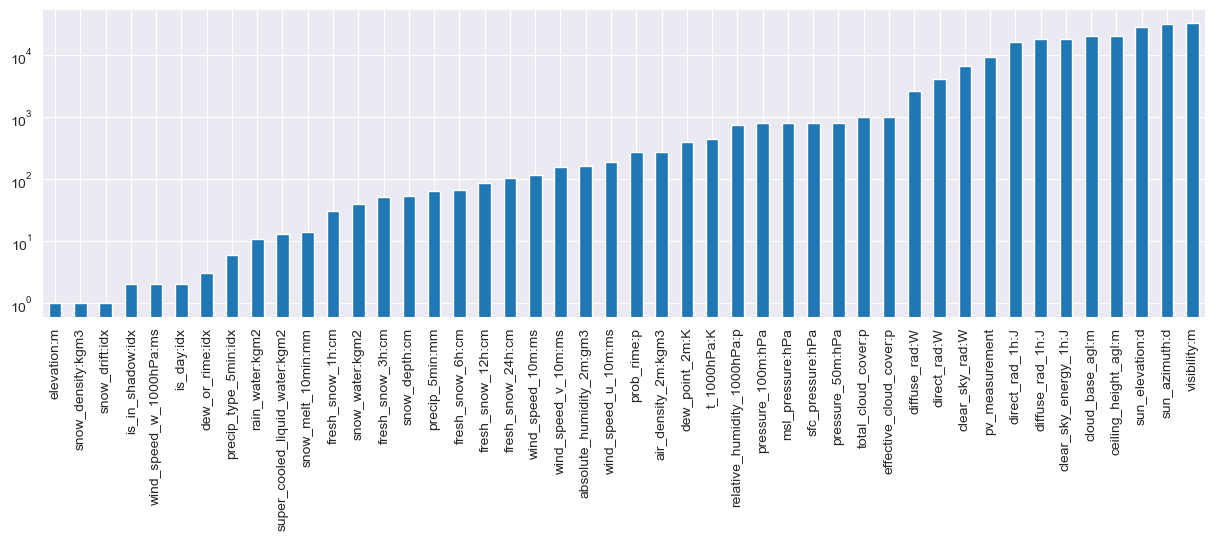

In [14]:
unique_values = df.select_dtypes(exclude='datetime').nunique().sort_values()
unique_values.plot.bar(logy=True, figsize=(15, 4))

From this we can see that most features are continuous, but three of the features are single valued. This means that they only have one value across all rows. This is something we need to investigate further:

In [15]:
df[['elevation:m', 'snow_density:kgm3', 'snow_drift:idx']].head(20)

,elevation:m,snow_density:kgm3,snow_drift:idx
0,6.0,NaN,0.0
1,6.0,NaN,0.0
2,6.0,NaN,0.0
3,6.0,NaN,0.0
4,6.0,NaN,0.0
5,6.0,NaN,0.0
6,6.0,NaN,0.0
7,6.0,NaN,0.0
8,6.0,NaN,0.0
9,6.0,NaN,0.0


These features have major issues and can therefor be removed from the dataset

In [16]:
df = df.drop(columns=['elevation:m', 'snow_density:kgm3', 'snow_drift:idx'], axis=1)
pd.value_counts(df.dtypes)

float32           42
datetime64[ns]     1
float64            1
Name: count, dtype: int64

As we can see, we now have three less float32 features, meaning that the features was properly removed.

# 2. Quality check

In [17]:
df.isna().sum()

absolute_humidity_2m:gm3             0
air_density_2m:kgm3                  0
ceiling_height_agl:m              7777
clear_sky_energy_1h:J                0
clear_sky_rad:W                      0
cloud_base_agl:m                  3063
dew_or_rime:idx                      0
dew_point_2m:K                       0
diffuse_rad:W                        0
diffuse_rad_1h:J                     0
direct_rad:W                         0
direct_rad_1h:J                      0
effective_cloud_cover:p              0
fresh_snow_12h:cm                    0
fresh_snow_1h:cm                     0
fresh_snow_24h:cm                    0
fresh_snow_3h:cm                     0
fresh_snow_6h:cm                     0
is_day:idx                           0
is_in_shadow:idx                     0
msl_pressure:hPa                     0
precip_5min:mm                       0
precip_type_5min:idx                 0
pressure_100m:hPa                    0
pressure_50m:hPa                     0
prob_rime:p              

We have a total of 7777 missing values in ceiling_height_agl:m and 3063 missing values in cloud_base_agl:m. There are too many missing values to remove the rows containing them, and we don't know the importance of the features yet, so we can't just remove them. Our only choice is then to impute them. A normal strategy for numeric features is using the mean of this feature:

In [18]:
imputer = SimpleImputer(strategy='mean')
df[['ceiling_height_agl:m', 'cloud_base_agl:m']] = imputer.fit_transform(df[['ceiling_height_agl:m', 'cloud_base_agl:m']])

In [19]:
df.isna().sum()

absolute_humidity_2m:gm3          0
air_density_2m:kgm3               0
ceiling_height_agl:m              0
clear_sky_energy_1h:J             0
clear_sky_rad:W                   0
cloud_base_agl:m                  0
dew_or_rime:idx                   0
dew_point_2m:K                    0
diffuse_rad:W                     0
diffuse_rad_1h:J                  0
direct_rad:W                      0
direct_rad_1h:J                   0
effective_cloud_cover:p           0
fresh_snow_12h:cm                 0
fresh_snow_1h:cm                  0
fresh_snow_24h:cm                 0
fresh_snow_3h:cm                  0
fresh_snow_6h:cm                  0
is_day:idx                        0
is_in_shadow:idx                  0
msl_pressure:hPa                  0
precip_5min:mm                    0
precip_type_5min:idx              0
pressure_100m:hPa                 0
pressure_50m:hPa                  0
prob_rime:p                       0
rain_water:kgm2                   0
relative_humidity_1000hPa:p 

All the null values is now removed

# REMEMBER TO FIND OUTLIERS

# 3. Shallow Feature Information
Considering the dimensionality of the dataset, analyzing each feature independently is close to impossible. Therefor, we will first plot each feature and only comment those with some interesting values.

## 3.1 Feature Distributions

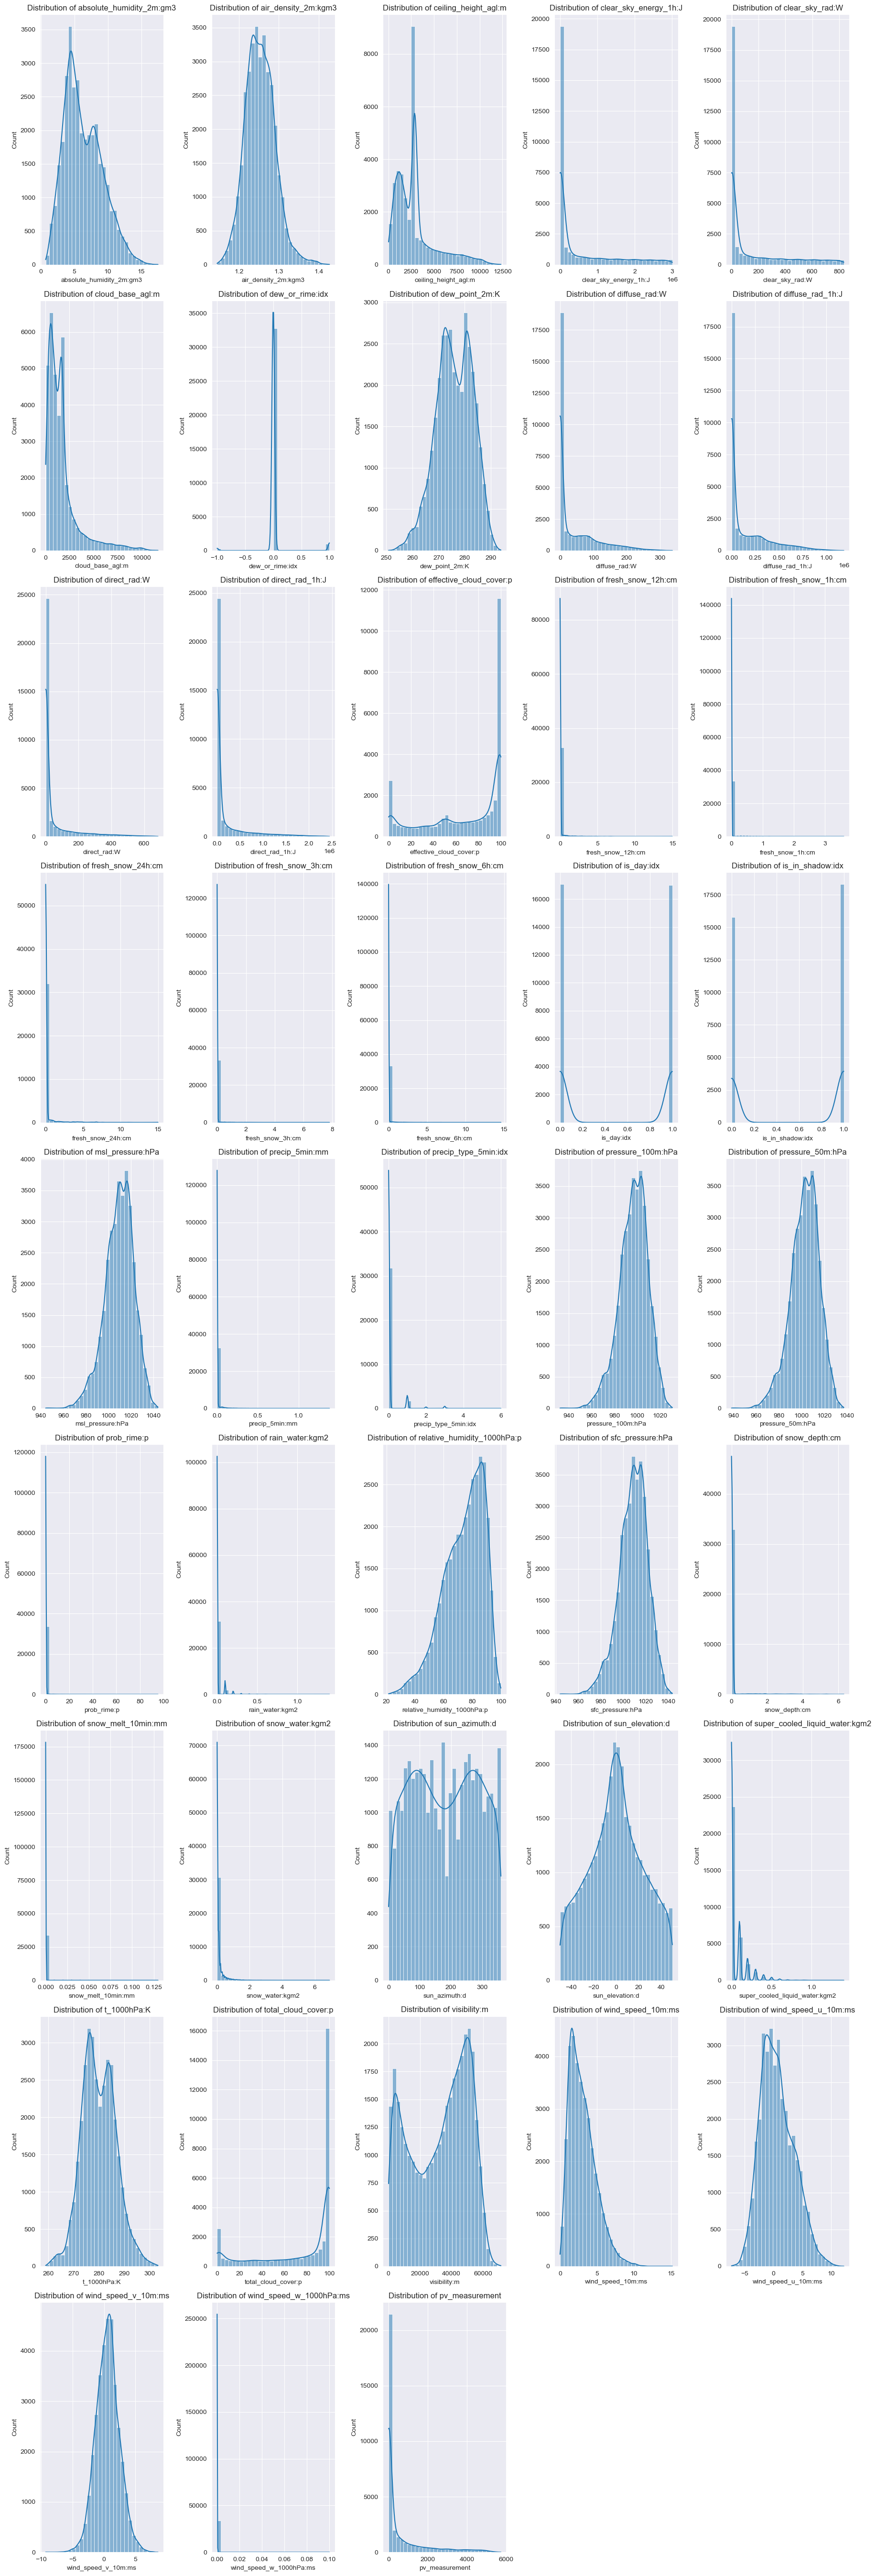

In [20]:
# Drop the index and target variable columns for feature distribution analysis
features_df = df.drop(columns=['time'])

# Plot the distribution of each feature
n_features = len(features_df.columns)
n_cols = 5
n_rows = (n_features // n_cols) + int(n_features % n_cols > 0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 6))
axes = axes.flatten()

for i, feature in enumerate(features_df.columns):
    sns.histplot(features_df[feature], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')

for i in range(n_features, n_cols * n_rows):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

absolute_humidity_2m:gm3: Shows a bimodal distribution, indicating two distinct groups or conditions in the dataset.

air_density_2m:kgm3: Almost normally distributed but has some outliers on the lower end.

ceiling_height_agl:m: Highly skewed to the right, meaning most of the values are clustered at the lower end.

clear_sky_energy_1h:J: Most values are zero, but there are some with higher values, indicating specific conditions where clear sky energy is non-zero.

total_cloud_cover:p: The distribution is almost binary, with most values at either 0 or 100, indicating clear sky or full cloud cover.

visibility:m: This feature also shows a bimodal distribution, indicating two different visibility conditions.

pv_measurement: Highly skewed towards the left. Indicating, most of the time, the solar power consumption is very low.

## 3.2 Linear Correlations

Highly Interdependent Features:
pressure_50m:hPa, sfc_pressure:hPa, and pressure_100m:hPa: These features have correlations very close to 1, indicating they are almost identical. One or two of these could likely be removed without losing much information.

dew_point_2m:K and absolute_humidity_2m:gm3: With a correlation of approximately 0.97, these variables are highly interrelated, suggesting redundancy.

clear_sky_energy_1h:J and clear_sky_rad:W: These also have a very high correlation of approximately 0.99, indicating potential redundancy.

Weather and Time-related Features:
fresh_snow_24h:cm, fresh_snow_12h:cm, fresh_snow_6h:cm, fresh_snow_3h:cm, and fresh_snow_1h:cm: These features are highly correlated with each other, ranging from 0.78 to 0.95, indicating they carry similar information about snowfall over different time periods.

solar_zenith_angle:d and sun_elevation:d: These features have a high negative correlation of -0.99, which makes sense because as the sun rises, the solar zenith angle decreases.

Correlations with Target Variable (pv_measurement):
clear_sky_energy_1h:J: This feature has a high positive correlation of 0.78 with the target variable 'pv_measurement', signifying its importance in predicting the target.

sun_elevation:d: This feature also shows a high positive correlation of 0.76 with the target variable, indicating its relevance in predicting solar energy production.

Other Interesting Correlations:
air_density_2m:kgm3 and t_1000hPa:K: These features have a high negative correlation of -0.91, which is logical given the inverse relationship between air density and temperature.

## 3.3 Non-linear Correlations

Highly Interdependent Features:
pressure_50m:hPa, sfc_pressure:hPa, and pressure_100m:hPa: These features have near-perfect Spearman correlations, suggesting they convey almost identical information. Consider dropping some to remove redundancy.

dew_point_2m:K and absolute_humidity_2m:gm3: With a Spearman correlation of around 0.97, these features are highly associated and possibly redundant.

clear_sky_energy_1h:J and clear_sky_rad:W: These have a Spearman correlation of around 0.99, further confirming their redundancy.

Weather and Time-related Features:
fresh_snow_24h:cm, fresh_snow_12h:cm, fresh_snow_6h:cm, fresh_snow_3h:cm, and fresh_snow_1h:cm: These features show high Spearman correlations ranging from 0.75 to 0.94, indicating they are capturing similar snowfall patterns over different time frames.

solar_zenith_angle:d and sun_elevation:d: Their Spearman correlation is -0.99, which is in line with their natural inverse relationship.

Correlations with Target Variable (pv_measurement):
    clear_sky_energy_1h:J: This has a Spearman correlation of 0.78 with the target variable, emphasizing its importance for prediction.

sun_elevation:d: This feature also has a Spearman correlation of 0.76 with the target variable, underlining its significance.

Other Interesting Correlations:
air_density_2m:kgm3 and t_1000hPa:K: These features have a Spearman correlation of -0.91, suggesting a robust inverse relationship even when accounting for non-linearities.

## 3.4 First Feature Extraction Based on Feature Redundancy

# 4 In-depth Feature Information

## 4.1 Feature Extraction for Further EDA

In [21]:
# Prepare the data
X = df.drop(columns=['pv_measurement', 'time'])  # Drop the index, target, and time columns
y = df['pv_measurement']  # Target variable

### 4.1.1 Using XGBoost

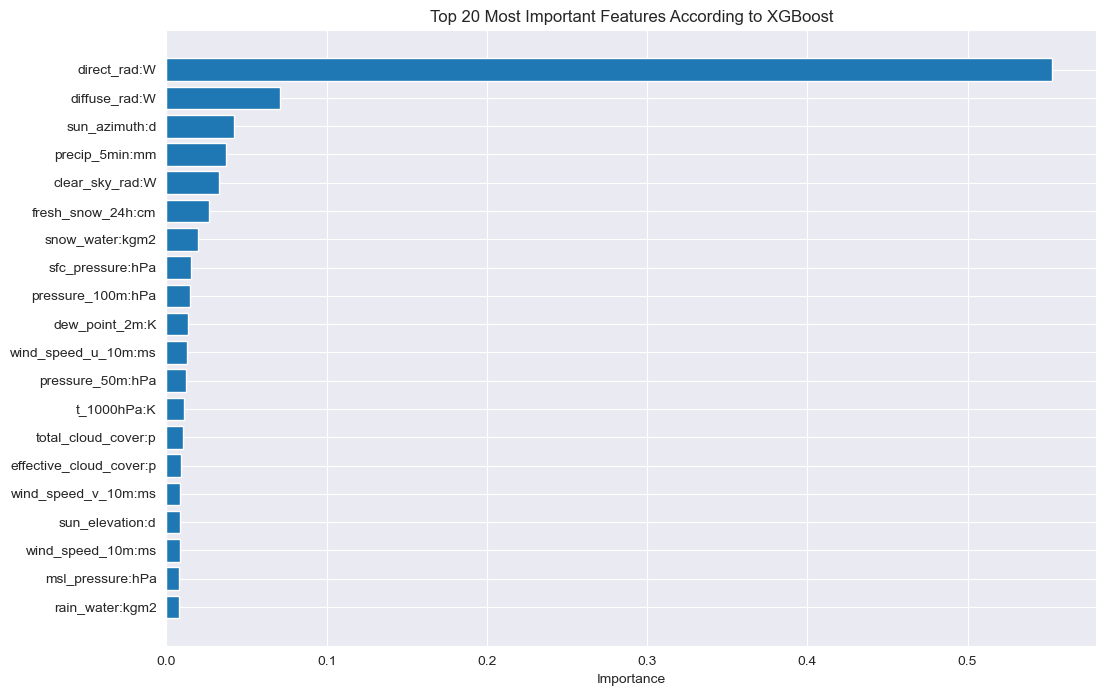

In [22]:
# Initialize and fit the XGBoost model
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X, y)

# Extract feature importances
feature_importances = xgb_model.feature_importances_

# Pair feature names with their importance scores
feature_importance_dict = dict(zip(X.columns, feature_importances))

# Sort the features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Extract the top 20 most important features
top_20_features = sorted_features[:20]

# Plotting the feature importances
plt.figure(figsize=(12, 8))
plt.barh([x[0] for x in reversed(top_20_features)], [x[1] for x in reversed(top_20_features)])
plt.xlabel('Importance')
plt.title('Top 20 Most Important Features According to XGBoost')
plt.show()

### 4.1.2 Using Mutual Information

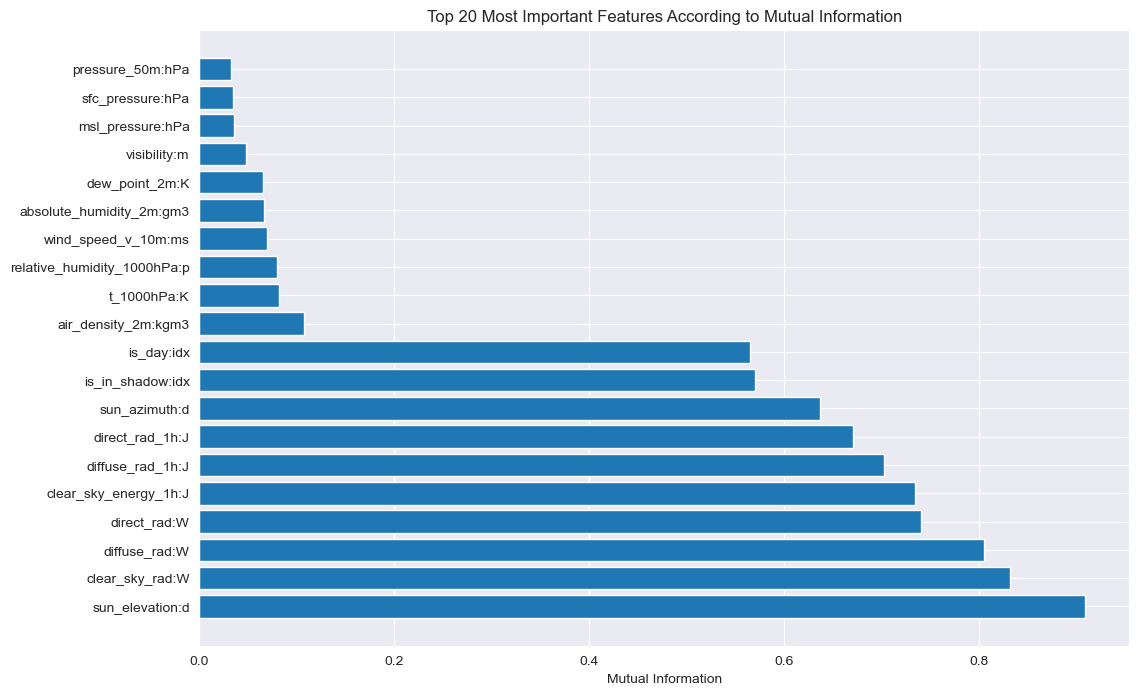

In [23]:
mi = mutual_info_regression(X, y)
mi_series = pd.Series(mi, index=X.columns)
mi_series.sort_values(ascending=False, inplace=True)

# Top 20 features based on Mutual Information
top_20_mi = mi_series[:20]

plt.figure(figsize=(12, 8))
plt.barh(top_20_mi.index, top_20_mi.values)
plt.xlabel('Mutual Information')
plt.title('Top 20 Most Important Features According to Mutual Information')
plt.show()

### 4.1.3 Using Recursive Feature Elimination

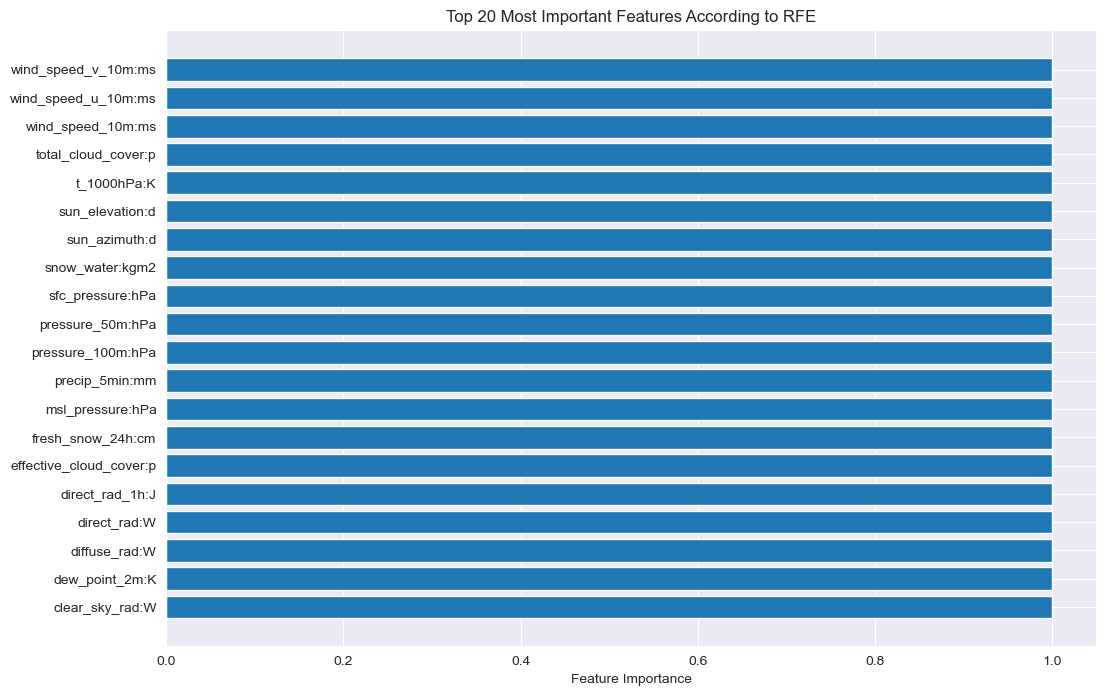

In [24]:
estimator = xgb.XGBRegressor()
selector = RFE(estimator, n_features_to_select=20, step=1)
selector = selector.fit(X, y)

top_20_rfe = pd.Series(selector.support_, index=X.columns)
top_20_rfe = top_20_rfe[top_20_rfe].index

# Plotting the top 20 most important features according to RFE
top_20_rfe

### 4.1.4 Using F-Regression

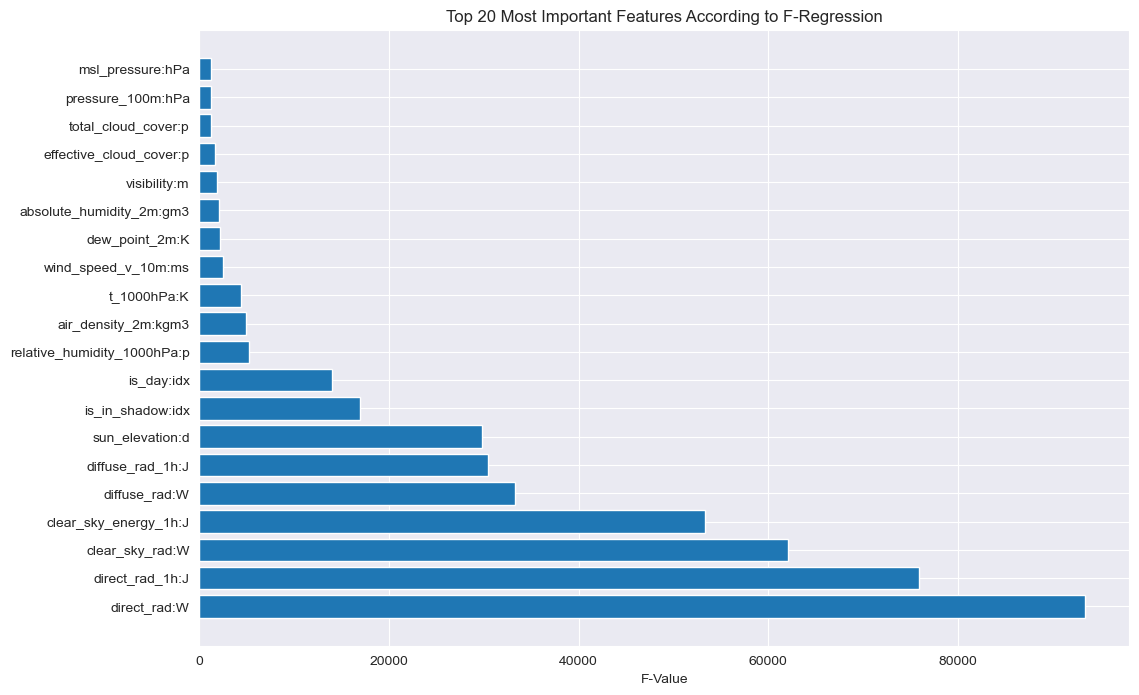

In [25]:
F_values, p_values = f_regression(X, y)
f_reg_series = pd.Series(F_values, index=X.columns)
f_reg_series.sort_values(ascending=False, inplace=True)

# Top 20 features based on F-Regression
top_20_f_reg = f_reg_series[:20]

plt.figure(figsize=(12, 8))
plt.barh(top_20_f_reg.index, top_20_f_reg.values)
plt.xlabel('F-Value')
plt.title('Top 20 Most Important Features According to F-Regression')
plt.show()

## 4.2 Seasonal Decomposition

## 4.3 Stationarity 

## 4.4 Autocorrelation (ACF/PACF)

# 5. Feature Engineering

## 5.1 Time based Features

In [26]:
def date_features(df):
    df['hour'] = pd.to_datetime(df['time']).dt.hour
    df['day'] = pd.to_datetime(df['time']).dt.dayofyear
    df['month'] = pd.to_datetime(df['time']).dt.month
    df['quarter'] = pd.to_datetime(df['time']).dt.quarter

    df['lagged_pv_measurement_1h'] = df['pv_measurement'].shift(1)
    df['lagged_pv_measurement_3h'] = df['pv_measurement'].shift(3)
    df['lagged_pv_measurement_6h'] = df['pv_measurement'].shift(6)

    df['rolling_mean_pv_measurement_3h'] = df['pv_measurement'].rolling(window=3).mean()
    return df

date_features(df)

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,...,time,pv_measurement,hour,day,month,quarter,lagged_pv_measurement_1h,lagged_pv_measurement_3h,lagged_pv_measurement_6h,rolling_mean_pv_measurement_3h
0,7.7,1.230,1744.900024,0.000000,0.0,1744.900024,0.0,280.299988,0.0,0.000000,...,2019-06-02 22:00:00,0.00,22,153,6,2,NaN,NaN,NaN,NaN
1,7.7,1.225,1703.599976,0.000000,0.0,1703.599976,0.0,280.299988,0.0,0.000000,...,2019-06-02 23:00:00,0.00,23,153,6,2,0.00,NaN,NaN,NaN
2,7.7,1.221,1668.099976,0.000000,0.0,1668.099976,0.0,280.200012,0.0,0.000000,...,2019-06-03 00:00:00,0.00,0,154,6,2,0.00,NaN,NaN,0.000000
3,8.2,1.218,1388.400024,0.000000,0.0,1388.400024,0.0,281.299988,0.0,0.000000,...,2019-06-03 01:00:00,0.00,1,154,6,2,0.00,0.00,NaN,0.000000
4,8.8,1.219,1108.500000,6546.899902,9.8,1108.500000,0.0,282.299988,4.3,7743.299805,...,2019-06-03 02:00:00,19.36,2,154,6,2,0.00,0.00,NaN,6.453333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34056,4.6,1.275,1633.000000,157319.796875,13.5,547.500000,0.0,272.500000,8.9,94492.000000,...,2023-04-30 19:00:00,9.02,19,120,4,2,194.70,907.72,3374.14,298.760000
34057,4.5,1.279,1742.900024,8133.899902,0.0,534.700012,0.0,272.299988,0.0,15967.400391,...,2023-04-30 20:00:00,0.00,20,120,4,2,9.02,692.56,2170.74,67.906667
34058,4.5,1.281,1794.900024,0.000000,0.0,565.900024,0.0,272.299988,0.0,0.000000,...,2023-04-30 21:00:00,0.00,21,120,4,2,0.00,194.70,686.84,3.006667
34059,4.5,1.281,1532.900024,0.000000,0.0,519.000000,0.0,272.299988,0.0,0.000000,...,2023-04-30 22:00:00,0.00,22,120,4,2,0.00,9.02,907.72,0.000000


In [27]:
# Make sure to have a column 'id' for each time series and 'time' for the time stamps
# extracted_features = extract_features(df, column_id='id', column_sort='time')